In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from encoder import *
from AttnDecoder import * 
from seq2seq import *

from build_dataset import *
from inference import *
from tqdm import tqdm

from beamsearch import *

/ext3/conda/1011_project/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/tb2817/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/tb2817/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 1. Load dataloaders 

In [2]:
# set whether or not model is pretrained
model_pretrained = True

In [3]:
# load data 
main_data_path = "data/processed"

train_file_path = {
    'source': f"{main_data_path}/src-train.txt",
    'target': f"{main_data_path}/tgt-train.txt"
}

test_file_path = {
    'source': f"{main_data_path}/src-test.txt",
    'target': f"{main_data_path}/tgt-test.txt"
}

dev_file_path = {
    'source': f"{main_data_path}/src-dev.txt",
    'target': f"{main_data_path}/tgt-dev.txt"
}

# build vocab with train data only 
vocab = build_train_vocab(train_file_path)

# build datasets for all train, test, dev
datasets = {
    'train': QAPair(train_file_path, vocab),
    'test': QAPair(test_file_path, vocab),
    'dev': QAPair(dev_file_path, vocab),
}

# build dataloaders
batch_size = 8
dataloaders = {}
for split, dataset in datasets.items():
    dataloaders[split] = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=partial(pad_collate_fn, pad_token=dataset.pad_idx)
    )

# 2. Load parsed GloVe embeddings

In [4]:
embed_size = 300
pretrained_vectors = {
    'enc': torch.load(f'embeddings/encoder_emb_{embed_size}.pt').float(),
    'dec': torch.load(f'embeddings/decoder_emb_{embed_size}.pt').float()
}

# input_size = len(train_dataset.answer_vocab) 
output_size = len(vocab['target'])

# 3. Train loop

## 3.1 Define train and eval steps

In [5]:
def train_step(batch, model, optimizer, criterion, device):
    input = batch.source_vecs.to(device) 
    inputs_len = batch.source_lens.to(device)
    target = batch.target_vecs.to(device)
    target_len = batch.target_lens.to(device) 
    target_input = target[:, :-1]
    
    model.train()

    dec_log_probs, dec_hidden, attn_scores_mat = model(input, target_input, inputs_len, target_len)
    
    optimizer.zero_grad()
    target_out = target[:, 1:]
    loss = criterion(dec_log_probs.transpose(1, 2), target_out)
    loss.backward()
    # clip gradients
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0, norm_type=2)
    
    optimizer.step()

    # return the attention scores at the last time step
    return loss.item(), dec_log_probs, attn_scores_mat

def eval_step(batch, model, criterion, device):
    input = batch.source_vecs.to(device) 
    inputs_len = batch.source_lens.to(device)
    target = batch.target_vecs.to(device)
    target_len = batch.target_lens.to(device) 
    target_input = target[:, :-1]
    
    model.eval()

    dec_log_probs, dec_hidden, attn_scores_mat = model(input, target_input, inputs_len, target_len)

    target_out = target[:, 1:]
    loss = criterion(dec_log_probs.transpose(1, 2), target_out)

    # return the attention scores at the last time step
    return loss.item(), dec_log_probs, attn_scores_mat
    

## 3.2 Run train loop

In [6]:
# TRAIN LOOP 

if not model_pretrained:
    # initial learning rate
    lr = 1.0
    # initialize the model, optimizer, and criterion
    seq2seq = Seq2Seq(pretrained_vectors, hidden_size=600, output_size=output_size)
    optimizer = torch.optim.SGD(seq2seq.parameters(), lr=lr)
    criterion = nn.NLLLoss(ignore_index=datasets['train'].pad_idx)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    seq2seq.to(device)

    plot_cache = {}
    plot_cache['train'] = []
    plot_cache['dev'] = []

    # halve lr at epoch 8
    scheduler = StepLR(optimizer, step_size=8, gamma=0.5) 

    NUM_EPOCHS = 15
    for epoch in tqdm(range(NUM_EPOCHS)):    
        # train 
        train_losses = []
        for i, data in tqdm(enumerate(dataloaders['train']), leave=False):
            curr_loss, dec_log_probs, attn_scores_mat = train_step(data, seq2seq, optimizer, criterion, device)

            train_losses.append(curr_loss)

        avg_train_loss = np.mean(train_losses)
        print(f'Train loss after epoch {epoch+1} = {avg_train_loss}')

        # eval 
        test_losses = []
        with torch.no_grad():
            for i, data in tqdm(enumerate(dataloaders['dev']), leave=False):
                curr_loss, dec_log_probs, attn_scores_mat = eval_step(data, seq2seq, criterion, device)

                test_losses.append(curr_loss)

            avg_test_loss = np.mean(test_losses)
            print(f'Test loss after epoch {epoch+1} = {avg_test_loss}')

        plot_cache['train'].append(avg_train_loss)
        plot_cache['dev'].append(avg_test_loss)

        scheduler.step()

    # save the model state
    torch.save({'state_dict': seq2seq.state_dict(), 'plot_cache': plot_cache}, 'trained_seq2seq_statedict.pt')
else:
    # reload the model
    seq2seq = Seq2Seq(pretrained_vectors, hidden_size=600, output_size=output_size)
    criterion = nn.NLLLoss(ignore_index=datasets['train'].pad_idx)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seq2seq.to(device)

    checkpoint = torch.load('trained_seq2seq_statedict.pt')
    seq2seq.load_state_dict(checkpoint['state_dict'])
    plot_cache = checkpoint['plot_cache']

In [7]:
# run inference on the test set
all_best_attn_labels = []
all_preds_list = []
all_labels_list = []
raw_labels_list = []
all_cleaned_preds_list = []
all_bleu_1 = []
all_bleu_2 = []
all_bleu_3 = []
all_bleu_4 = []
all_meteor = []
all_rouge_l = []
all_attn_score_list = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['test']), leave=False):
        # run beam search inference on the test set
        preds_list, labels_list, attn_score_list = beam_search_batch(data, seq2seq, vocab['target'], device, beam_width=1)
        all_attn_score_list.append(attn_score_list)
        # create a matrix of the best attention score SRC token class 
        best_attn_labels_list = unk_postprocessing(data.source_vecs, attn_score_list)
        # all_best_attn_labels.append(best_attn_labels)

        # evaluate the predictions with the metrics
        bleu_1, bleu_2, bleu_3, bleu_4, meteor, rouge_l = eval_metrics(preds_list, labels_list) # meteor, rouge_l
        all_bleu_1.append(bleu_1)
        all_bleu_2.append(bleu_2)
        all_bleu_3.append(bleu_3)
        all_bleu_4.append(bleu_4)
        all_meteor.append(meteor)
        all_rouge_l.append(rouge_l)

                # clean the targets and the labels - remove the special tokens
        # for targets, also replace all unk tokens with the SRC token with the highest attention
        clean_preds_list = []
        clean_labels_list = []
        for batch_idx in range(len(labels_list)):
            label = labels_list[batch_idx]
            pred = preds_list[batch_idx]
            clean_label = []
            clean_pred = []
            for token in label:
                if token == '<bos>':
                    pass
                elif token == '<eos>':
                    break
                else:
                    clean_label.append(token)
            for token_idx, token in enumerate(pred):
                if token == '<unk>':
                    src_id = int(best_attn_labels_list[batch_idx][token_idx].item())
                    src_token = vocab['source'].decode_idx2token([src_id])
                    clean_pred.append('<' + src_token[0] + '>')
                if token == '<bos>':
                    pass
                elif token == '<eos>':
                    break
                else:
                    clean_pred.append(token)
            clean_preds_list.append(clean_pred)
            clean_labels_list.append(clean_label)

            all_preds_list.append(preds_list[batch_idx])

        # all_labels_list.append(labels_list)
        # all_cleaned_preds_list.append(clean_preds_list)
        # all_cleaned_labels_list.append(clean_labels_list)
        # raw_labels_list.append(data.target_data)
        break

    avg_bleu_1 = np.mean(all_bleu_1)
    avg_bleu_2 = np.mean(all_bleu_2)
    avg_bleu_3 = np.mean(all_bleu_3)
    avg_bleu_4 = np.mean(all_bleu_4)
    avg_meteor = np.mean(all_meteor)
    avg_rouge_l = np.mean(all_rouge_l)

    print(f'Average BLEU_1 Score = {avg_bleu_1}')
    print(f'Average BLEU_2 Score = {avg_bleu_2}')
    print(f'Average BLEU_3 Score = {avg_bleu_3}')
    print(f'Average BLEU_4 Score = {avg_bleu_4}')
    print(f'Average METEOR Score = {avg_meteor}')
    print(f'Average ROUGE_L Score = {avg_rouge_l}')

Average BLEU_1 Score = 0.2597066652600376
Average BLEU_2 Score = 0.06765117696257344
Average BLEU_3 Score = 0.031068279407918453
Average BLEU_4 Score = 0.0
Average METEOR Score = 0.25079828739243126
Average ROUGE_L Score = 0.24216270446777344


In [10]:
raw_labels_list

[]

In [14]:
# print out a few postprocesse predictions
for i in range(8):
    print('Source (Answer) Sentence:\t', " ".join(data.source_data[i]))
    print('Target (Question) Label:', " ".join(data.target_data[i]))
    print('Target (Question) Raw Prediction:', " ".join(all_preds_list[i]))
    print('Target (Question) Postprocessed Prediction:', " ".join(clean_preds_list[i]))
    print('')

Source (Answer) Sentence:	 on december 19 , 2011 , then mayor michael r. bloomberg announced his choice of cornell university and technion-israel institute of technology to build a us$ 2 billion graduate school of applied sciences called cornell tech on roosevelt island with the goal of transforming new york city into the world 's premier technology capital .
Target (Question) Label: what is the cost to build cornell tech ?
Target (Question) Raw Prediction: what program did forbes university in 2011 ?
Target (Question) Postprocessed Prediction: what program did forbes university in 2011 ?

Source (Answer) Sentence:	 the 1825 completion of the erie canal through central new york connected the atlantic port to the agricultural markets and commodities of the north american interior via the hudson river and the great lakes .
Target (Question) Label: the erie canal was finished being built in what year ?
Target (Question) Raw Prediction: what is the capital in new york connected the atlanti

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(torch.transpose(attentions, 0, 1), cmap='bone', aspect='auto')
    fig.colorbar(cax)

    print('input_sentence: ', input_sentence)
    print('output_words: ', output_words)
    
    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words.split(' '))

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [ ]:
sample_set_preds = all_cleaned_preds_list[0]
sample_set_attns = all_attn_score_list[0]

print('sample_set_preds size: ', len(sample_set_preds))
print('sample_set_attns size: ', len(sample_set_attns))

for idx, prediction in enumerate(sample_set_preds): 
    pred_sentence = ' '.join(prediction)
    print('prediction sentence: ', pred_sentence)
    print('attention size: ', sample_set_attns[idx].size()) 
    #print('attention: ', all_attn_score_list[0][idx]) 

    attn_matrix = torch.Tensor.cpu(sample_set_attns[idx][:len(data.source_data[idx])])
    label = raw_labels_list[0][idx]
    showAttention(' '.join(data.source_data[idx]), ' '.join(prediction), attn_matrix)

In [10]:
# PLOT TRAIN AND VAL LOSS
import matplotlib.pyplot as plt 
def plot_over_training(per_epoch_metrics, title_name, subtitle_name, num_epochs):
    t = np.arange(1, num_epochs+1)

    fig, ax1 = plt.subplots()

    colors = ['tab:blue', 'tab:red']
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')

    for key, color in zip(per_epoch_metrics, colors):
        label = f'{key}_loss' if key != 'test' else 'val_loss'
        ax1.plot(t, per_epoch_metrics[key], color=color, linewidth=1, label=label)

    ax1.tick_params(axis='y')
    ax1.legend(loc='upper right')

    fig.tight_layout
    plt.suptitle(title_name, fontsize=14, y=1)
    plt.title(subtitle_name, fontsize=10)
    plt.show()


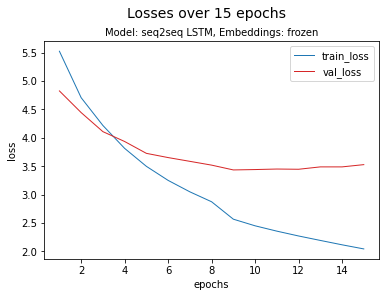

In [11]:
plot_over_training(plot_cache, 'Losses over 15 epochs', 'Model: seq2seq LSTM, Embeddings: frozen', 15)